In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fs = 50e6 # Sampling Frequency (MHz)
n = 512 # Samples
T = n/fs # Chirp duration (s)
n_chirps = 512

d0 = 30 # Distance (m)
v = - 30 # Velocity (m/s)
c = 3e8 # Light Speed (m/s)
f0 = 77e9 # Signal Frequency (GHz)
B = 600e6 # Chirp bandwidth (Hz)
delta_t = 2 * d0 / c # Time to recieve signal (s)

print('Number of Samples: {}'.format(n))
print('Sampling Duration: {:.2e}'.format(n/fs))
print('Frequency Resolution: {:.2e}'.format(fs / n))
print()

t_linear = np.linspace(0, T*n_chirps, n*n_chirps)
t_doppler = t_linear - 2/c*(d0 + v*t_linear)

signal_equation = lambda t: np.exp(2j * np.pi * (f0 * t + ((t%T)**2)*B/(2*T)))

linear_signal = signal_equation(t_linear)
doppler_signal = signal_equation(t_doppler)
# doppler_signal = signal_equation(t_doppler) + np.random.normal(0, 1, t_doppler.shape)

doppler_signal[0:int(delta_t * fs)] = 0

# doppler_signal = np.concatenate((np.zeros(int(delta_t * fs)), doppler_signal))[:-int(delta_t * fs)]
# non_doppler_signal = np.concatenate((np.zeros(int(delta_t * fs)), linear_signal))[:-int(delta_t * fs)]

Number of Samples: 512
Sampling Duration: 1.02e-05
Frequency Resolution: 9.77e+04



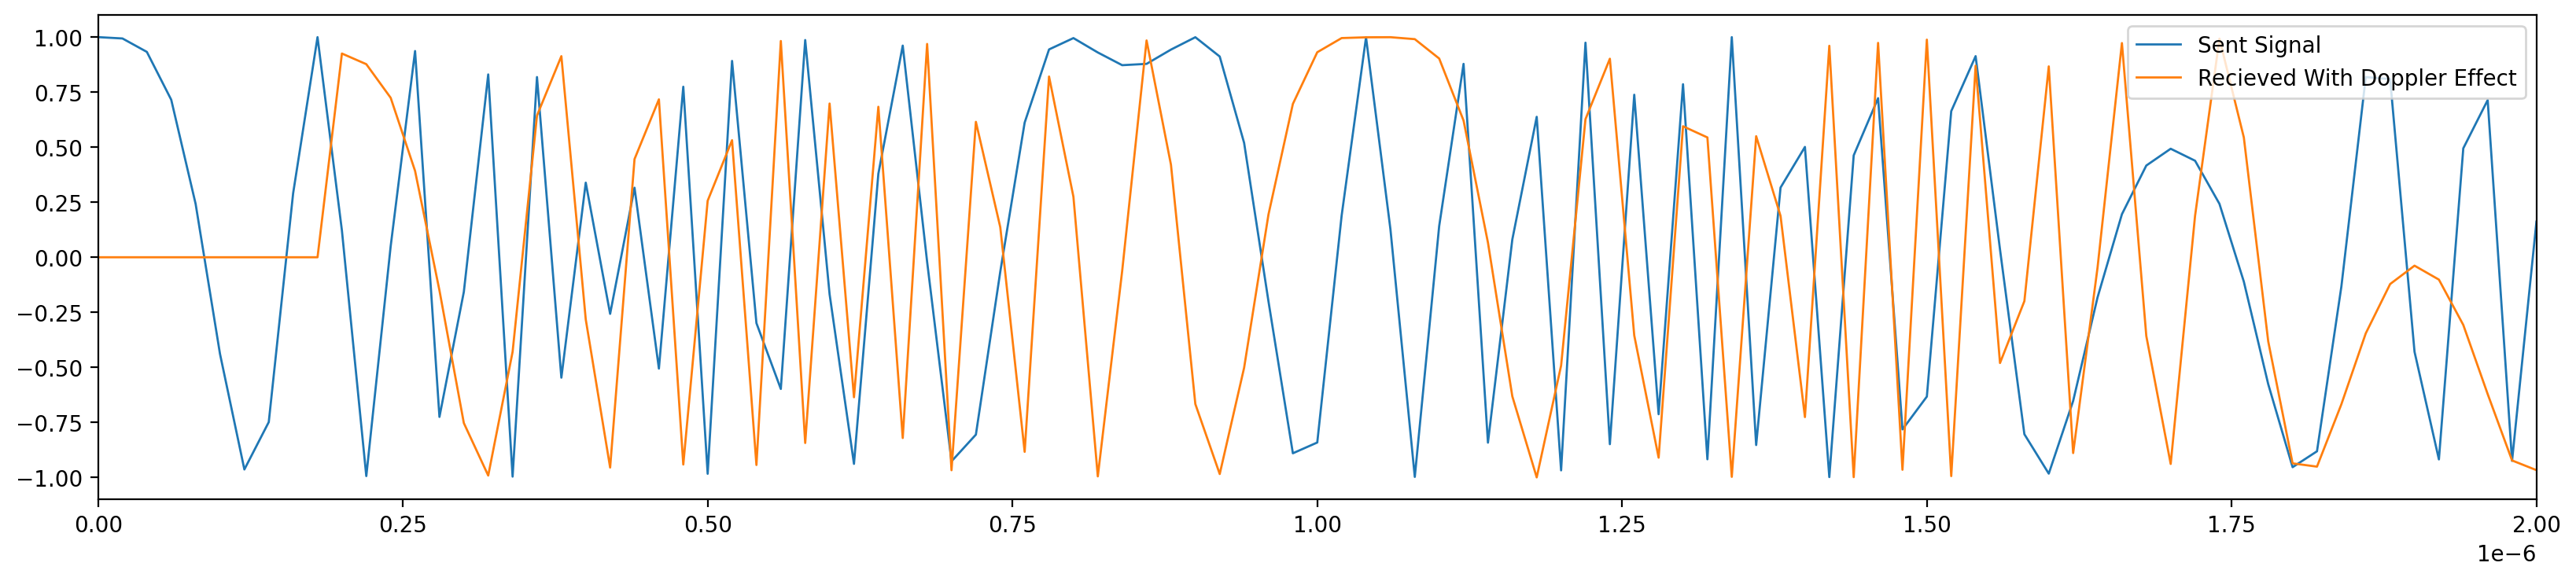

In [3]:
plt.figure(figsize=(20,4), dpi=200)
# plt.title('Not acctually the signal because the Nyquist Frequency is not beeing respected, but it illustrate the signals sent and recieved')
plt.plot(t_linear, np.real(linear_signal), label='Sent Signal', linewidth=1)
plt.plot(t_linear, np.real(doppler_signal), label='Recieved With Doppler Effect', linewidth=1)
plt.xlim((0, 0.2e-5))
# plt.plot(t_linear, np.real(if_signal))
# plt.plot(t_linear, np.real(non_doppler_signal), label='Recieved Without Doppler Effect')
plt.legend()
plt.show()

In [4]:
# if_signal = np.conj(linear_signal)*doppler_signal
# if_non_doppler_signal = np.conj(linear_signal)*non_doppler_signal

if_signal = linear_signal * np.conj(doppler_signal)
# if_non_doppler_signal = linear_signal * np.conj(non_doppler_signal)

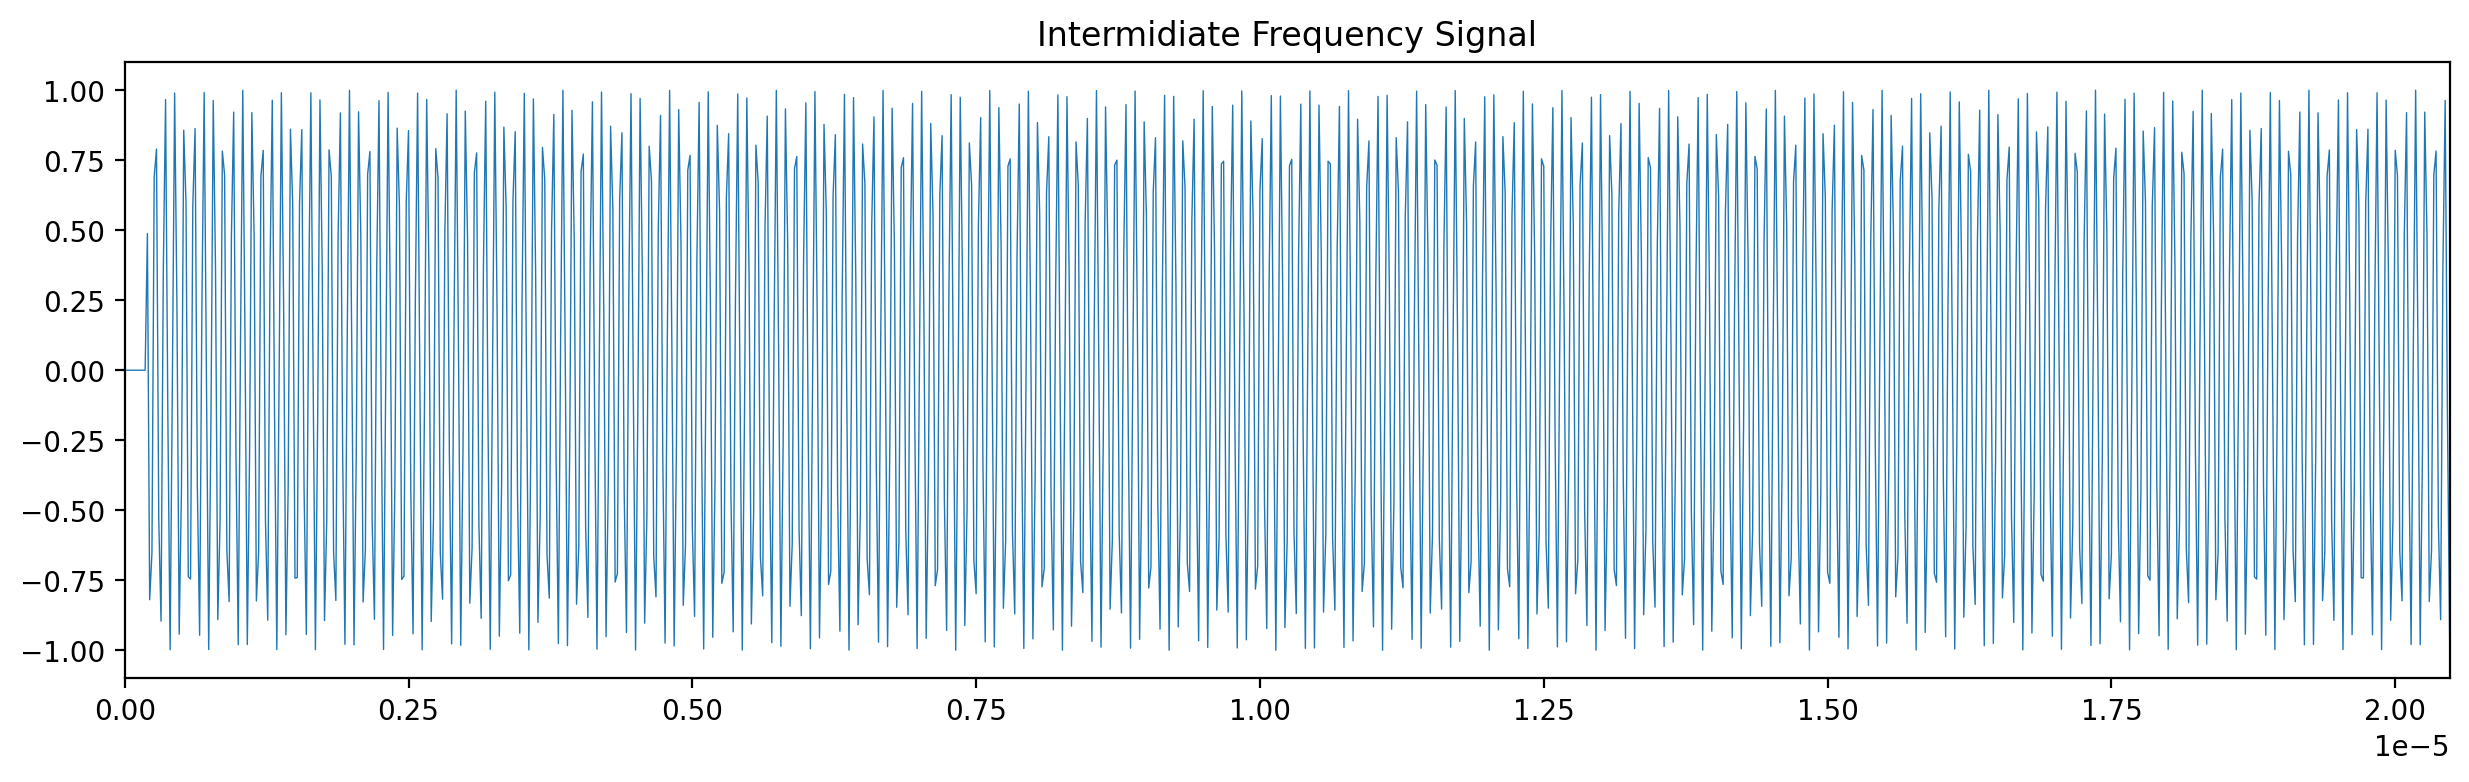

In [5]:
plt.figure(figsize=(15,4), dpi=200)
plt.title('Intermidiate Frequency Signal')
plt.plot(t_linear, np.real(if_signal), label='IF signal', linewidth=0.5)
# plt.plot(t_linear, np.real(if_non_doppler_signal), label='Recieved without doppler effect')
plt.xlim([np.min(t_linear), np.max(t_linear)*2/n_chirps])
plt.show()

In [6]:
recieved_signal = []

for chirp in range(n_chirps):
    recieved_fft = np.fft.fft(if_signal[n * chirp : n * (chirp + 1)])
    recieved_fft = np.fft.fftshift(recieved_fft)
    recieved_signal.append(recieved_fft)
    
recieved_frequency_fft = np.fft.fftfreq(n, 1/fs)
recieved_frequency_fft = np.fft.fftshift(recieved_frequency_fft)


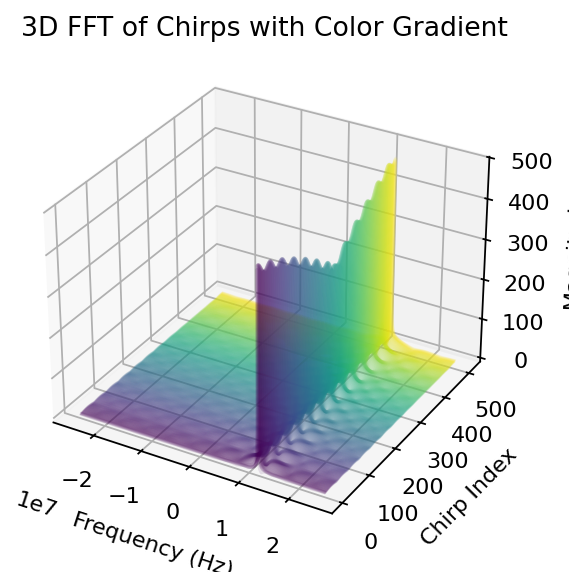

In [7]:
# 3D Plot
fig = plt.figure(figsize=[4,6], dpi=160)
ax = fig.add_subplot(111, projection='3d')

# Get a colormap (e.g., 'viridis')
cmap = plt.get_cmap('viridis', n_chirps)

for chirp in reversed(range(n_chirps)):
    ax.plot(
        recieved_frequency_fft,        # x-axis: frequency
        np.abs(recieved_signal[chirp]),     # y-axis: magnitude
        zs=chirp,                      # z-axis: chirp index
        zdir='y',                      # Project along the y-axis
        color=cmap(chirp),             # Apply color gradient
        label=f'Chirp {chirp}',
        alpha = 0.1
    )

# Labels
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Chirp Index')
ax.set_zlabel('Magnitude')
ax.set_title('3D FFT of Chirps with Color Gradient')

plt.show()

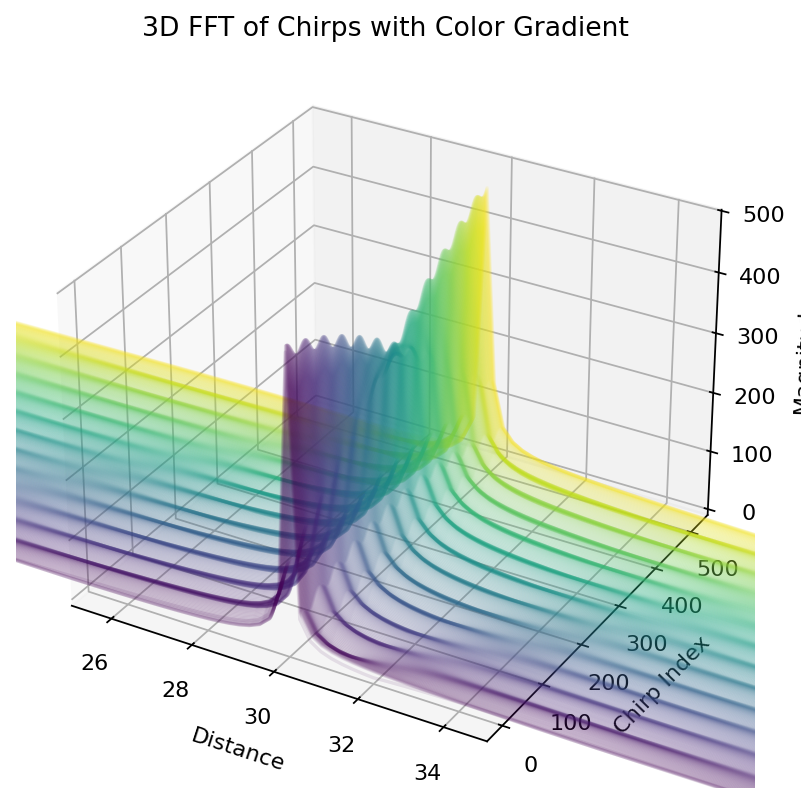

In [8]:
distance = (c * recieved_frequency_fft * T) / (2 * B)

# 3D Plot
fig = plt.figure(figsize=[6,6], dpi=160)
ax = fig.add_subplot(111, projection='3d')

# Get a colormap (e.g., 'viridis')
cmap = plt.get_cmap('viridis', n_chirps)

for chirp in reversed(range(n_chirps)):
    ax.plot(
        distance,        # distance
        np.abs(recieved_signal[chirp]),     # y-axis: magnitude
        zs=chirp,                      # z-axis: chirp index
        zdir='y',                      # Project along the y-axis
        color=cmap(chirp),             # Apply color gradient
        label=f'Chirp {chirp}',
        alpha = 0.1
    )

# Labels
ax.set_xlabel('Distance')
ax.set_xlim([25,35])
ax.set_ylabel('Chirp Index')
ax.set_zlabel('Magnitude')
ax.set_title('3D FFT of Chirps with Color Gradient')

plt.show()

In [9]:
second_fft = np.fft.fft(recieved_signal, axis=0)
second_fft = np.fft.fftshift(second_fft, axes=0)
doppler_freqs = np.fft.fftfreq(n_chirps, d=T/n_chirps)
doppler_freqs = np.fft.fftshift(doppler_freqs)

wave_length = c / f0

velocity = doppler_freqs * wave_length / 2

print(f'Velocity Frequency Resolution: {wave_length / (2*T*n_chirps)}')

Velocity Frequency Resolution: 0.371561421976461


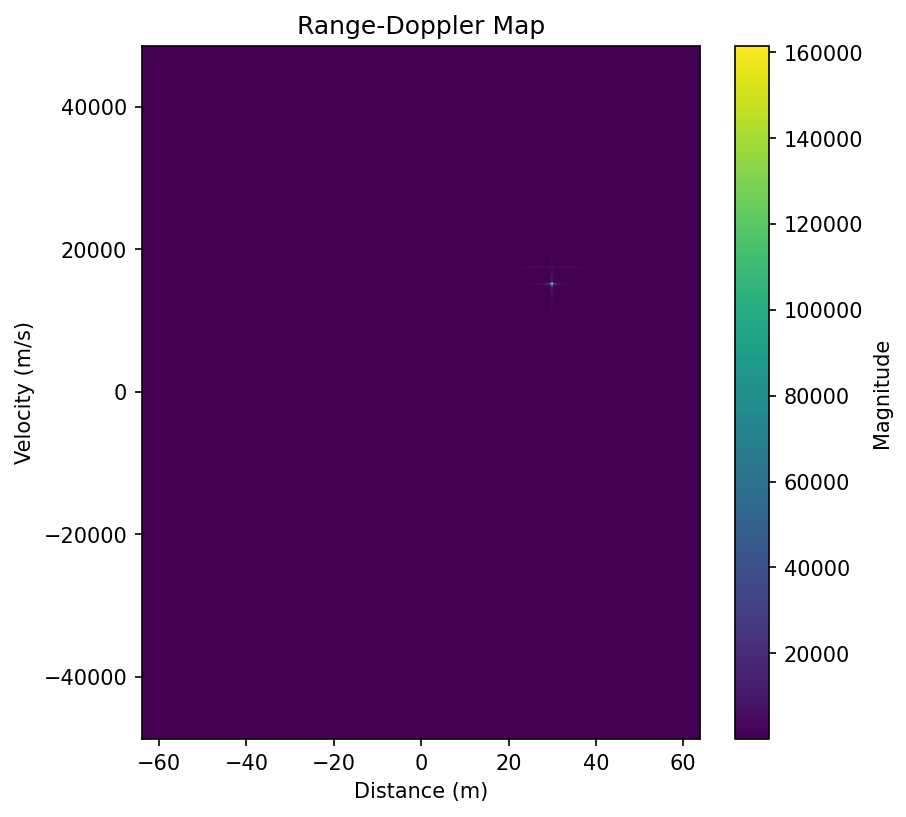

In [10]:
plt.figure(figsize=(6, 6), dpi=150)
plt.imshow(np.abs(second_fft), aspect='auto', extent=[distance.min(), distance.max(), velocity.min(), velocity.max()], cmap='viridis')
plt.colorbar(label='Magnitude')
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (m/s)')
plt.title('Range-Doppler Map')
plt.show()